# Informe nº7.1
    Notas: breve actualización del TFG. Comprobación del método propuesto en el infome 7.
    Fecha: 07/08/2020
   
   ### Comprobación de los resutados obtenidos por el método propuesto en el informe anterior
    A continuación se exponen los resultados obtenidos con el método propuesto en el informe antetior con algunas de las imágenes disponibles en el respositorio, comparandolos con los obtenidos en las lescturas de los piranómetros.

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn
!pip install seaborn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sn
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from datetime import timedelta
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

### Cielos despejados
    Intentaremos observar como afecta a la radiaión estimada la variación del número de sectores en los que dividimos el cielo. Para estos ejemplos utilizaremos el ángulo sólido definido por un intervalo en el ángulo azimut.

C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: divide by zero encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))
C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: invalid value encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))


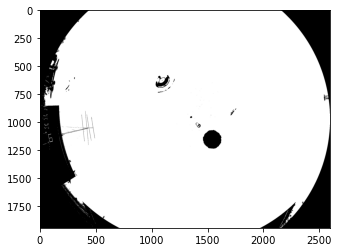

In [2]:
# Pre-procesado de la imágen
path_img_despejado = 'Fotos Cielo/imagen_original_2020-05-20-14h49min.jpg'
img_despejado = cv2.imread(path_img_despejado, cv2.IMREAD_COLOR)
img_despejado = pre_procesado(img_despejado)

# Se obtiene la hora de la imágen
hora_img = hora_imagen(path_img_despejado)
res_sol = sol_cubierto(img_despejado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

# Se obtienen las máscaras del cielo y de las nubes de la imágenes
mask_nubes = mascara_nubes(img_despejado, centroide_img)
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

mask_sol = mascara_solar(img_despejado)
mask_no_sol = cv2.bitwise_not(mask_sol, mask=cielo)
mask_cielo = cv2.bitwise_and(mask_cielo, mask_no_sol, mask=cielo)

muestra_imagen(mask_cielo)

# Obtenemos la radiación difusa estimada
pd_info_regresion_despejado = pd.read_csv('Datos/info_regresion_despejado_completo.csv')
radiacion_global_medida = pd_info_regresion_despejado.set_index('Unnamed: 0.1').loc[hora_img.strftime('%Y-%m-%d %H:%M:%S')]['Radiacion']
ratio_nubes = porcion_nubes_cielo(mask_nubes)
intens_media = intensidad_media(img_despejado, mask=mask_cielo, coseno=True, gamma=2.2) / 255

rad_estimada = rad_difusa(radiacion_global_medida, ratio_nubes, factor_solar, intens_media, cielo='despejado')
radiacion_medida = pd_info_regresion_despejado.set_index('Unnamed: 0.1').loc[hora_img.strftime('%Y-%m-%d %H:%M:%S')]['Radiacion difusa']

La radiación difusa percibida en el sector 1 del cielo es: 19.60 W/m2
La radiación difusa percibida en el sector 2 del cielo es: 17.40 W/m2
La radiación difusa percibida en el sector 3 del cielo es: 19.84 W/m2
La radiación difusa percibida en el sector 4 del cielo es: 20.58 W/m2
La radiación total difusa percibida en el cielo es: 77.43 W/m2
La radiación total difusa medida en el cielo es: 47.93 W/m2


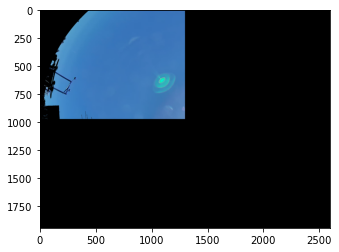

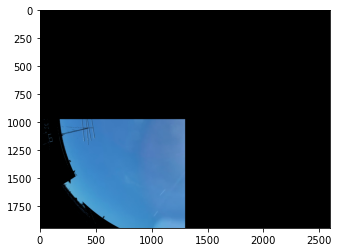

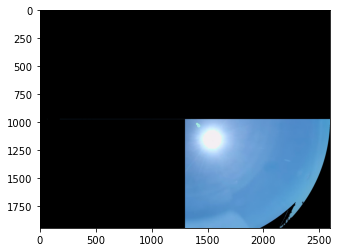

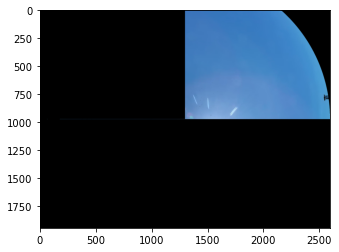

In [3]:
# División del cielo en N sectores definidos por los ángulos azimutales y cenitales
N = 4

matriz_posicion = matriz_posiciones()
pixels_zeniths = matriz_posicion[:,:,0]
pixels_azimuths = matriz_posicion[:,:,1]

azimuts = [360/N*i for i in range(N+1)]

n=0; rad_estimada_total=0
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
        
        # Se muestra el sector correspondiente
        plt.figure(n)
        muestra_imagen(cv2.bitwise_and(img_despejado, img_despejado, mask=mask_A))
        
        cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_A, mask=cielo))
        cielo_despejado_total = cv2.countNonZero(mask_cielo)
        ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total
        
        # Estimación de la radiación en este sector
        rad_difusa_estimada = rad_estimada * ratio_cielo_despejado
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} W/m2'.format(n, rad_difusa_estimada))
        
        rad_estimada_total += rad_difusa_estimada
    n+=1
    min_azimut = azimut

print('La radiación total difusa percibida en el cielo es: {:.2f} W/m2'.format(rad_estimada_total))
print('La radiación total difusa medida en el cielo es: {:.2f} W/m2'.format(radiacion_medida))

Observamos que la radiación estimada es mínima en el 2do sector, dónde la porción del cielo visible es inferior, y máxima en el sector 4, dónde se observa que prácticamente no hay ningún objecto que nos impida observar el cielo.

In [4]:
# Resultado de dividir el cielo en distintos sectores
Ns = range(2,8)

for N in Ns:
    azimuts = [360/N*i for i in range(N+1)]

    n=0; rad_estimada_total=0
    for azimut in azimuts:
        max_azimut = azimut
        if max_azimut != 0:
            mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
            mask_A = cv2.bitwise_and(mask_A, cielo)

            cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_A, mask=cielo))
            cielo_despejado_total = cv2.countNonZero(mask_cielo)
            ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total
            
            rad_difusa_estimada = rad_estimada * ratio_cielo_despejado

            rad_estimada_total += rad_difusa_estimada
        n+=1
        min_azimut = azimut

    print('La radiación total difusa percibida, con una división del cielo en {:} sectores, es: {:.2f} W/m2'.format(N, rad_estimada_total))

La radiación total difusa percibida, con una división del cielo en 2 sectores, es: 77.39 W/m2
La radiación total difusa percibida, con una división del cielo en 3 sectores, es: 77.37 W/m2
La radiación total difusa percibida, con una división del cielo en 4 sectores, es: 77.43 W/m2
La radiación total difusa percibida, con una división del cielo en 5 sectores, es: 77.37 W/m2
La radiación total difusa percibida, con una división del cielo en 6 sectores, es: 77.39 W/m2
La radiación total difusa percibida, con una división del cielo en 7 sectores, es: 77.37 W/m2


Se observa de la radiación estimada se mantiene practicamente constante ante la variación del número de sectores en los que se divide el cielo.

### Cielos nublados


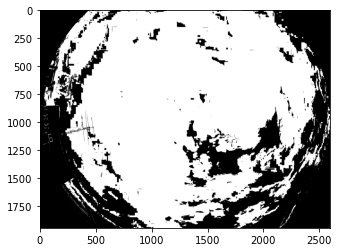

In [5]:
# Pre-procesado de la imágen
path_img_nublado = 'Fotos Cielo/imagen_original_2020-05-10-15h56min.jpg'
img_nublado = cv2.imread(path_img_nublado, cv2.IMREAD_COLOR)
img_nublado = pre_procesado(img_nublado)

# Se obtiene la hora de la imágen
hora_img = hora_imagen(path_img_nublado)
res_sol = sol_cubierto(img_nublado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

# Se obtiene las máscara de nubes y cielo de la imágen
mask_nubes = mascara_nubes(img_nublado)
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

muestra_imagen(mask_nubes)
    
ghi = rad_gh_teorica(hora_img)
ratio_nubes = porcion_nubes_cielo(mask_nubes)
intens_media = intensidad_media(img_nublado, mask_nubes, gamma=2.2) / 255

pd_info_regresion_nublado = pd.read_csv('Datos/info_regresion_nublado_completo.csv')
rad_estimada = rad_difusa(ghi, ratio_nubes, factor_solar, intens_media, cielo='nublado')
radiacion_medida = pd_info_regresion_nublado.set_index('Unnamed: 0.1').loc[hora_img.strftime('%Y-%m-%d %H:%M:%S')]['Radiacion difusa']

La radiación difusa percibida en el sector 1 del cielo es: 83.51 W/m2
La radiación difusa percibida en el sector 2 del cielo es: 66.54 W/m2
La radiación difusa percibida en el sector 3 del cielo es: 49.13 W/m2
La radiación difusa percibida en el sector 4 del cielo es: 86.59 W/m2
La radiación total difusa percibida en el cielo es: 285.78 W/m2
La radiación total difusa medida en el cielo es: 275.87 W/m2


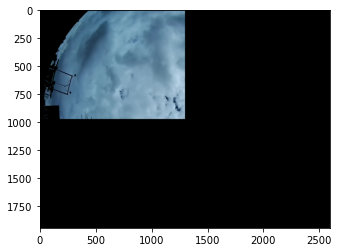

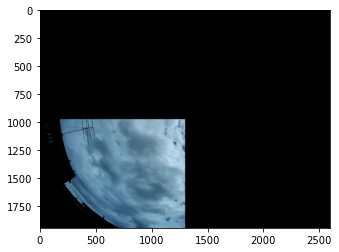

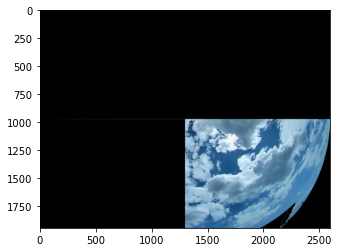

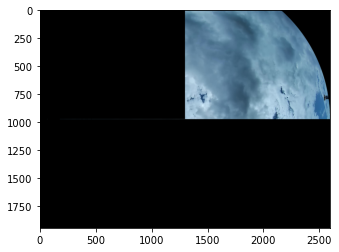

In [6]:
# División del cielo en N sectores definidos por los ángulos azimutales y cenitales
N = 4
# N = rand(0:5)

azimuts = [360/N*i for i in range(N+1)]

n=0; rad_estimada_total=0
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
    
        plt.figure(n)
        muestra_imagen(cv2.bitwise_and(img_nublado, img_nublado, mask=mask_A))
        
        cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_nubes, mask_A, mask=cielo))
        cielo_despejado_total = cv2.countNonZero(mask_nubes)
        ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total
        
        rad_difusa_estimada = rad_estimada * ratio_cielo_despejado
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} W/m2'.format(n, rad_difusa_estimada))
        
        rad_estimada_total += rad_difusa_estimada
    n+=1
    min_azimut = azimut
    
print('La radiación total difusa percibida en el cielo es: {:.2f} W/m2'.format(rad_estimada_total))
print('La radiación total difusa medida en el cielo es: {:.2f} W/m2'.format(radiacion_medida))

Observamos que la mayor radiacion se percibe en los sectores 1 y 4, ya que son los que más nublados se encuentran, también vemos que el sector 2 presenta una catidad de nubes elevada, pero parte del cielo se encuentra tapado por los edificios cercanos a los instrumentos de medida. Por último, observamos que la menor radiación se ecuentra en el sector 3, ya que la cantidad de nubes en este es inferior.

In [7]:
# Resultado de dividir el cielo en distintos sectores
Ns = range(2,8)

for N in Ns:
    azimuts = [360/N*i for i in range(N+1)]

    n=0; rad_estimada_total=0
    for azimut in azimuts:
        max_azimut = azimut
        if max_azimut != 0:
            mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
            mask_A = cv2.bitwise_and(mask_A, cielo)

            cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_nubes, mask_A, mask=cielo))
            cielo_despejado_total = cv2.countNonZero(mask_nubes)
            ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total
            rad_difusa_estimada = rad_estimada * ratio_cielo_despejado

            rad_estimada_total += rad_difusa_estimada
        n+=1
        min_azimut = azimut

    print('La radiación total difusa percibida, con una división del cielo en {:} sectores, es: {:.2f} W/m2'.format(N, rad_estimada_total))

La radiación total difusa percibida, con una división del cielo en 2 sectores, es: 285.59 W/m2
La radiación total difusa percibida, con una división del cielo en 3 sectores, es: 285.52 W/m2
La radiación total difusa percibida, con una división del cielo en 4 sectores, es: 285.78 W/m2
La radiación total difusa percibida, con una división del cielo en 5 sectores, es: 285.52 W/m2
La radiación total difusa percibida, con una división del cielo en 6 sectores, es: 285.59 W/m2
La radiación total difusa percibida, con una división del cielo en 7 sectores, es: 285.52 W/m2


De forma similar a los cielos despejados, se observa que la variación del número de sectores en los que se divide la imágen no afecta significativamente a la estimación obtenida de la radiación difusa.